# Reconstructing the Mitochondrial Proton Motive Force Using Physics-Informed Neural Networks and Surrogate Bioenergetic Signals

**Mark I.R. Petalcorin**\
**Aaidea Ltd, U.K.**\
*mark.petalcorin@a-aidea.com*

In [28]:
# Synthetic ETC to PMF dataset generator, curriculum ready
# Author: Mark I.R. Petalcorin
import numpy as np
import pandas as pd
from dataclasses import dataclass
from typing import Tuple, Dict, Any, List
from scipy.integrate import solve_ivp

# physical constants
R = 8.314        # J per mol per K
T = 310.0        # K
F = 96485.0      # C per mol
K_MV_PER_PH = 2.303 * R * T / F * 1000.0   # about 61.5 mV per pH unit


# simple ODE toy model of ETC, produces steady state features
# this is not a full mechanistic model, it is a controllable generator

@dataclass
class ETCParams:
    kNADH: float = 1.2         # scales supply from NADH to flux
    kO2: float = 1.0           # scales oxygen control on terminal step
    kLeak: float = 0.35        # scales proton leak
    kROS: float = 0.15         # scales ROS coupling
    kBuffer: float = 3.0       # pH buffering strength
    kATPuse: float = 0.6       # consumption pulls on PMF
    base_dpsi: float = 140.0   # mV, baseline membrane potential
    base_dpH: float = 0.3      # baseline pH gradient

def etc_ode(t, y, u, p: ETCParams):
    """
    y[0] = dpsi, membrane potential in mV
    y[1] = dpH, proton gradient in pH units
    controls u: dict with nadh, o2, flux_set, leak_scale, ros_drive
    """
    dpsi, dpH = y
    nadh = u["nadh"]
    o2 = u["o2"]
    flux_set = u["flux_set"]
    leak_scale = u["leak_scale"]
    ros_drive = u["ros_drive"]

    # effective electron flux, limited by both NADH and O2
    flux = flux_set * np.tanh(p.kNADH * nadh) * np.tanh(p.kO2 * o2)

    # proton pumping from flux builds both dpsi and dpH, leak discharges them
    build_dpsi = 45.0 * flux
    build_dpH = 0.015 * flux

    leak_term_dpsi = p.kLeak * leak_scale * (dpsi - p.base_dpsi)
    leak_term_dpH  = 0.25 * p.kLeak * leak_scale * (dpH - p.base_dpH)

    # ATP usage pulls PMF which couples to dpsi and dpH sinks
    atp_pull_dpsi = 0.25 * p.kATPuse * (dpsi - p.base_dpsi)
    atp_pull_dpH  = 0.12 * p.kATPuse * (dpH - p.base_dpH)

    # ROS perturbs both with small random kicks toward depolarization and acidification
    ros_push_dpsi = -0.8 * p.kROS * ros_drive
    ros_push_dpH  = -0.005 * p.kROS * ros_drive

    ddpsi = build_dpsi - leak_term_dpsi - atp_pull_dpsi + ros_push_dpsi
    ddpH  = build_dpH  - leak_term_dpH  - atp_pull_dpH  + ros_push_dpH

    # buffer dpH dynamics
    ddpH /= (1.0 + p.kBuffer)

    return [ddpsi, ddpH]

def simulate_one(u: Dict[str, float], p: ETCParams, t_end: float = 4.0) -> Tuple[float, float]:
    # start near baseline to help convergence
    y0 = [p.base_dpsi, p.base_dpH]
    sol = solve_ivp(
        fun=lambda t, y: etc_ode(t, y, u, p),
        t_span=(0.0, t_end),
        y0=y0,
        method="RK45",
        rtol=1e-6,
        atol=1e-8,
        max_step=0.05
    )
    dpsi, dpH = sol.y[0, -1], sol.y[1, -1]
    return float(dpsi), float(dpH)

# dataset factory, supports curriculum and domain randomization
@dataclass
class GenConfig:
    n: int = 60000
    seed: int = 7
    hypoxia_frac: float = 0.25            # fraction of low oxygen samples
    curriculum_level: int = 3             # 1 simple, 2 medium, 3 full
    noise_dpsi_std: float = 6.0           # mV
    noise_dpH_std: float = 0.08           # pH units
    save_csv: str = None                  # path to save, optional

def sample_controls(cfg: GenConfig, rng: np.random.Generator) -> Dict[str, float]:
    # oxygen, enforce hypoxia balance
    if rng.random() < cfg.hypoxia_frac:
        o2 = rng.uniform(0.01, 0.35)
    else:
        o2 = rng.uniform(0.4, 1.0)

    # curriculum controls
    if cfg.curriculum_level == 1:
        nadh = rng.uniform(0.6, 1.0)
        flux_set = rng.uniform(0.5, 1.0)
        leak_scale = rng.uniform(0.8, 1.2)
        ros_drive = rng.uniform(0.0, 0.4)
    elif cfg.curriculum_level == 2:
        nadh = rng.uniform(0.2, 1.0)
        flux_set = rng.uniform(0.3, 1.0)
        leak_scale = rng.uniform(0.6, 1.6)
        ros_drive = rng.uniform(0.0, 0.8)
    else:
        nadh = rng.uniform(0.0, 1.0)
        flux_set = rng.uniform(0.1, 1.2)
        leak_scale = rng.uniform(0.4, 1.8)
        ros_drive = rng.uniform(0.0, 1.2)

    return dict(nadh=nadh, o2=o2, flux_set=flux_set, leak_scale=leak_scale, ros_drive=ros_drive)

def generate_dataset(cfg: GenConfig, params: ETCParams = ETCParams()) -> pd.DataFrame:
    rng = np.random.default_rng(cfg.seed)
    rows: List[Dict[str, Any]] = []

    for _ in range(cfg.n):
        u = sample_controls(cfg, rng)
        dpsi, dpH = simulate_one(u, params, t_end=4.0)

        # compute PMF from identity
        pmf = dpsi - K_MV_PER_PH * dpH

        # add realistic measurement noise
        dpsi_noisy = dpsi + rng.normal(0.0, cfg.noise_dpsi_std)
        dpH_noisy  = dpH  + rng.normal(0.0, cfg.noise_dpH_std)
        pmf_noisy  = dpsi_noisy - K_MV_PER_PH * dpH_noisy

        rows.append(dict(
            NADH=u["nadh"],
            Oxygen=u["o2"],
            FluxSet=u["flux_set"],
            LeakScale=u["leak_scale"],
            ROS=u["ros_drive"],
            dpsi_true=dpsi,
            dpH_true=dpH,
            PMF_true=pmf,
            dpsi_meas=dpsi_noisy,
            dpH_meas=dpH_noisy,
            PMF_meas=pmf_noisy,
            hypoxia=int(u["o2"] < 0.4)
        ))

    df = pd.DataFrame(rows)

    # light clipping to biological ranges
    df["dpsi_meas"] = df["dpsi_meas"].clip(-50.0, 200.0)
    df["dpH_meas"]  = df["dpH_meas"].clip(-1.0, 1.5)
    df["PMF_meas"]  = df["PMF_meas"].clip(-150.0, 250.0)

    if cfg.save_csv:
        df.to_csv(cfg.save_csv, index=False)
    return df


# convenience, build multi phase curriculum and concatenate
def build_curriculum(n_total: int = 90000, seed: int = 7, path: str = None) -> pd.DataFrame:
    share = n_total // 3
    cfg1 = GenConfig(n=share, seed=seed, curriculum_level=1, hypoxia_frac=0.10)
    cfg2 = GenConfig(n=share, seed=seed+1, curriculum_level=2, hypoxia_frac=0.20)
    cfg3 = GenConfig(n=n_total - 2*share, seed=seed+2, curriculum_level=3, hypoxia_frac=0.35)
    df = pd.concat([
        generate_dataset(cfg1),
        generate_dataset(cfg2),
        generate_dataset(cfg3)
    ], ignore_index=True)
    if path:
        df.to_csv(path, index=False)
    return df


# example usage
if __name__ == "__main__":
    df = build_curriculum(n_total=60000, seed=11, path="pmf_synthetic_curriculum.csv")
    print(df.head())
    print("saved to, pmf_synthetic_curriculum.csv, rows,", len(df))

       NADH    Oxygen   FluxSet  LeakScale       ROS   dpsi_true  dpH_true  \
0  0.840599  0.699567  0.514345   0.859170  0.371284  159.743711  0.303058   
1  0.747597  0.773130  0.755695   1.065137  0.110124  166.418477  0.304770   
2  0.926695  0.707429  0.774538   1.192365  0.081804  166.984664  0.305165   
3  0.694120  0.754957  0.901101   1.146933  0.051504  168.468032  0.305368   
4  0.771979  0.314621  0.573846   1.069345  0.080886  149.577575  0.301706   

     PMF_true   dpsi_meas  dpH_meas    PMF_meas  hypoxia  
0  141.100063  163.162069  0.298572  144.794341        0  
1  147.669494  164.143886  0.341819  143.115715        0  
2  148.211388  169.354556  0.251519  153.881456        0  
3  149.682241  173.851528  0.286718  156.213091        0  
4  131.017096  148.335836  0.236624  133.779059        1  
saved to, pmf_synthetic_curriculum.csv, rows, 60000


In [93]:
# Train a small PyTorch NN on pmf_synthetic_curriculum.csv
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load dataset
df = pd.read_csv("pmf_synthetic_curriculum.csv")

# Features and target
features = ["NADH", "Oxygen", "FluxSet", "LeakScale", "ROS"]
target = ["PMF_true"]

X = df[features].values.astype(np.float32)
y = df[target].values.astype(np.float32)

# Train/val/test split
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=df["hypoxia"]
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.1, random_state=42
)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Convert to tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_val_t   = torch.tensor(X_val, dtype=torch.float32)
y_val_t   = torch.tensor(y_val, dtype=torch.float32)
X_test_t  = torch.tensor(X_test, dtype=torch.float32)
y_test_t  = torch.tensor(y_test, dtype=torch.float32)

# Build DataLoaders
train_ds = TensorDataset(X_train_t, y_train_t)
val_ds   = TensorDataset(X_val_t, y_val_t)
test_ds  = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=128, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=128, shuffle=False)

# Define simple neural network
class PMFNet(nn.Module):
    def __init__(self, input_dim=5, hidden_dim=64, output_dim=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, x):
        return self.net(x)

model = PMFNet()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
n_epochs = 50
for epoch in range(n_epochs):
    # Training
    model.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    train_loss /= len(train_loader.dataset)

# Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            preds = model(xb)
            loss = criterion(preds, yb)
            val_loss += loss.item() * xb.size(0)
    val_loss /= len(val_loader.dataset)

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{n_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# Test evaluation
model.eval()
with torch.no_grad():
    test_preds = model(X_test_t).numpy().flatten()
    test_true  = y_test_t.numpy().flatten()

from sklearn.metrics import r2_score, mean_squared_error
print("Test R²:", r2_score(test_true, test_preds))
print("Test RMSE:", np.sqrt(mean_squared_error(test_true, test_preds)))

Epoch 10/50 - Train Loss: 1.5562, Val Loss: 1.4735
Epoch 20/50 - Train Loss: 0.3705, Val Loss: 0.3422
Epoch 30/50 - Train Loss: 0.1750, Val Loss: 0.1515
Epoch 40/50 - Train Loss: 0.1095, Val Loss: 0.0930
Epoch 50/50 - Train Loss: 0.0723, Val Loss: 0.0574
Test R²: 0.9994921088218689
Test RMSE: 0.24830539627965428


In [95]:
# PINN for PMF reconstruction
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error

# constants
K_MV_PER_PH = 61.5  # mV per pH unit (310K)

# load dataset
df = pd.read_csv("pmf_synthetic_curriculum.csv")

# features and labels
features = ["NADH", "Oxygen", "FluxSet", "LeakScale", "ROS"]
X = df[features].values.astype(np.float32)
y_pmf = df["PMF_true"].values.astype(np.float32).reshape(-1, 1)
y_dpsi = df["dpsi_true"].values.astype(np.float32).reshape(-1, 1)
y_dph = df["dpH_true"].values.astype(np.float32).reshape(-1, 1)

# torch tensors
X_t = torch.tensor(X)
y_pmf_t = torch.tensor(y_pmf)
y_dpsi_t = torch.tensor(y_dpsi)
y_dph_t = torch.tensor(y_dph)

# dataset
dataset = TensorDataset(X_t, y_pmf_t, y_dpsi_t, y_dph_t)

# split train/val/test
n_total = len(dataset)
n_train = int(0.7 * n_total)
n_val = int(0.15 * n_total)
n_test = n_total - n_train - n_val
train_ds, val_ds, test_ds = random_split(dataset, [n_train, n_val, n_test])

train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=256)
test_loader = DataLoader(test_ds, batch_size=256)

# PINN model
class PINN(nn.Module):
    def __init__(self, input_dim=5, hidden_dim=64):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2)   # outputs Δψ and ΔpH
        )
    def forward(self, x):
        return self.net(x)  # [Δψ, ΔpH]

model = PINN()

# loss functions
mse = nn.MSELoss()

def pinn_loss(outputs, y_pmf, y_dpsi, y_dph):
    dpsi_pred, dph_pred = outputs[:, 0:1], outputs[:, 1:2]
    pmf_pred = dpsi_pred - K_MV_PER_PH * dph_pred

    # supervised losses
    loss_dpsi = mse(dpsi_pred, y_dpsi)
    loss_dph  = mse(dph_pred, y_dph)
    loss_pmf  = mse(pmf_pred, y_pmf)

    # physics consistency: pmf consistency constraint
    loss_phys = mse(pmf_pred, dpsi_pred - K_MV_PER_PH * dph_pred)

    # total loss: combine
    total_loss = loss_pmf + 0.5*(loss_dpsi + loss_dph) + 0.1*loss_phys
    return total_loss, pmf_pred

# training loop
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 50

for epoch in range(epochs):
    model.train()
    train_losses = []
    for Xb, y_pmf_b, y_dpsi_b, y_dph_b in train_loader:
        optimizer.zero_grad()
        outputs = model(Xb)
        loss, _ = pinn_loss(outputs, y_pmf_b, y_dpsi_b, y_dph_b)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    val_losses = []
    model.eval()
    with torch.no_grad():
        for Xb, y_pmf_b, y_dpsi_b, y_dph_b in val_loader:
            outputs = model(Xb)
            loss, _ = pinn_loss(outputs, y_pmf_b, y_dpsi_b, y_dph_b)
            val_losses.append(loss.item())
    print(f"Epoch {epoch+1}/{epochs} TrainLoss={np.mean(train_losses):.4f} ValLoss={np.mean(val_losses):.4f}")

# evaluation on test set
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for Xb, y_pmf_b, y_dpsi_b, y_dph_b in test_loader:
        outputs = model(Xb)
        dpsi_pred, dph_pred = outputs[:, 0:1], outputs[:, 1:2]
        pmf_pred = dpsi_pred - K_MV_PER_PH * dph_pred
        y_true.append(y_pmf_b.numpy())
        y_pred.append(pmf_pred.numpy())

y_true = np.vstack(y_true)
y_pred = np.vstack(y_pred)

r2 = r2_score(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"Test R² = {r2:.3f}, RMSE = {rmse:.2f} mV")

Epoch 1/50 TrainLoss=14058.5159 ValLoss=11649.9685
Epoch 2/50 TrainLoss=7918.0972 ValLoss=1100.7081
Epoch 3/50 TrainLoss=193.0377 ValLoss=105.3019
Epoch 4/50 TrainLoss=99.7228 ValLoss=90.0424
Epoch 5/50 TrainLoss=86.1288 ValLoss=78.6411
Epoch 6/50 TrainLoss=74.7833 ValLoss=68.4214
Epoch 7/50 TrainLoss=64.9753 ValLoss=58.9473
Epoch 8/50 TrainLoss=56.4843 ValLoss=50.6452
Epoch 9/50 TrainLoss=48.2233 ValLoss=43.7426
Epoch 10/50 TrainLoss=41.2557 ValLoss=48.7089
Epoch 11/50 TrainLoss=34.9247 ValLoss=30.5126
Epoch 12/50 TrainLoss=28.4383 ValLoss=27.7762
Epoch 13/50 TrainLoss=23.8137 ValLoss=20.1904
Epoch 14/50 TrainLoss=19.1034 ValLoss=17.0270
Epoch 15/50 TrainLoss=15.0296 ValLoss=13.0870
Epoch 16/50 TrainLoss=12.0322 ValLoss=14.7457
Epoch 17/50 TrainLoss=10.0198 ValLoss=9.0061
Epoch 18/50 TrainLoss=8.5099 ValLoss=7.3966
Epoch 19/50 TrainLoss=7.0947 ValLoss=6.4120
Epoch 20/50 TrainLoss=6.3430 ValLoss=5.9621
Epoch 21/50 TrainLoss=6.3305 ValLoss=6.0823
Epoch 22/50 TrainLoss=5.3542 ValLoss=5.3

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/800 [00:00<?, ?it/s]

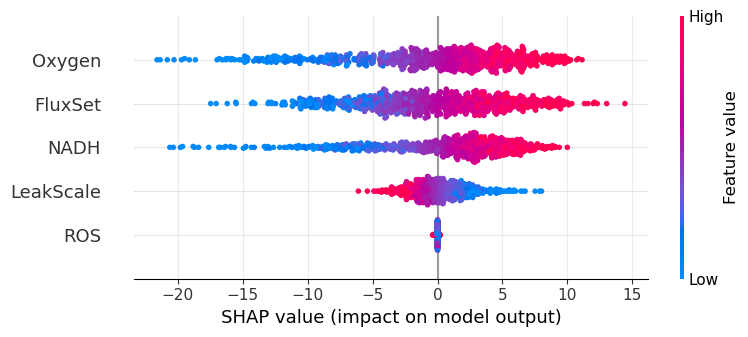

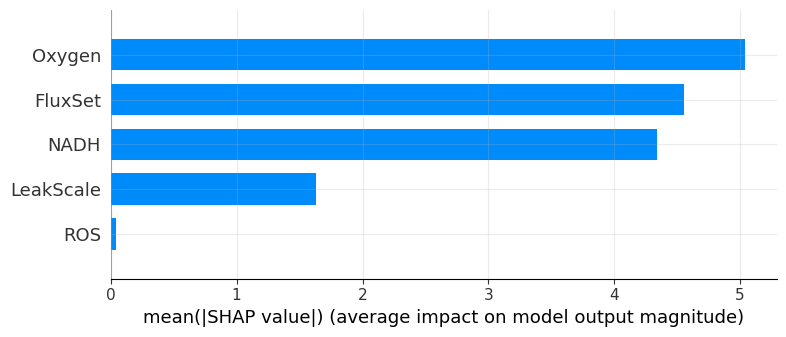

<Figure size 700x450 with 0 Axes>

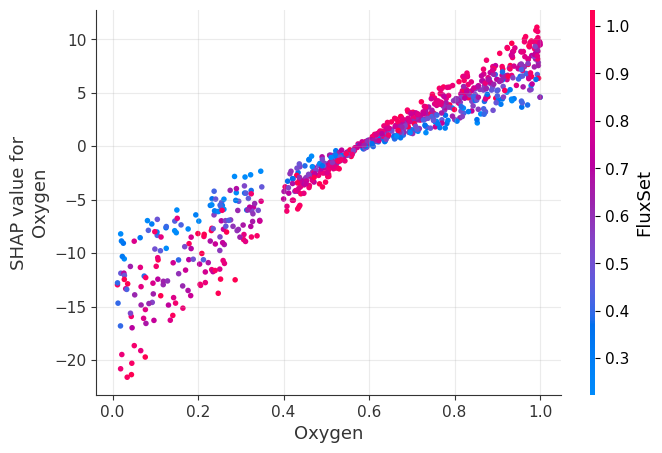

In [97]:
# SHAP interpretability for PMF predictions
import numpy as np
import shap
import torch
import matplotlib.pyplot as plt

model.eval()

feature_names = ["NADH", "Oxygen", "FluxSet", "LeakScale", "ROS"]

# prediction wrapper, input numpy, output numpy PMF
def predict_pmf_numpy(x_np: np.ndarray) -> np.ndarray:
    with torch.no_grad():
        xt = torch.tensor(x_np.astype(np.float32))
        out = model(xt)                         # columns, dpsi, dpH
        dpsi = out[:, 0:1]
        dph  = out[:, 1:2]
        pmf  = dpsi - 61.5 * dph                # k at 310 K in mV per pH
        return pmf.cpu().numpy().ravel()        # shape, n

# pick small background for speed, and a sample to explain
rng = np.random.default_rng(123)
idx_bg = rng.choice(len(X), size=min(200, len(X)), replace=False)
idx_ex = rng.choice(len(X), size=min(800, len(X)), replace=False)

X_bg = X[idx_bg].astype(np.float32)
X_explain = X[idx_ex].astype(np.float32)

# build explainer
explainer = shap.KernelExplainer(predict_pmf_numpy, X_bg)

# compute shap values
shap_values = explainer.shap_values(X_explain)

# summary plot, feature impact across samples
plt.figure()
shap.summary_plot(shap_values, X_explain, feature_names=feature_names, show=True)

# bar plot of mean absolute shap, global importance
plt.figure()
shap.summary_plot(shap_values, X_explain, feature_names=feature_names, plot_type="bar", show=True)

# optional, dependence plot for the top feature
top_feat = int(np.argmax(np.mean(np.abs(shap_values), axis=0)))
plt.figure()
shap.dependence_plot(top_feat, shap_values, X_explain, feature_names=feature_names, show=True)

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/800 [00:00<?, ?it/s]

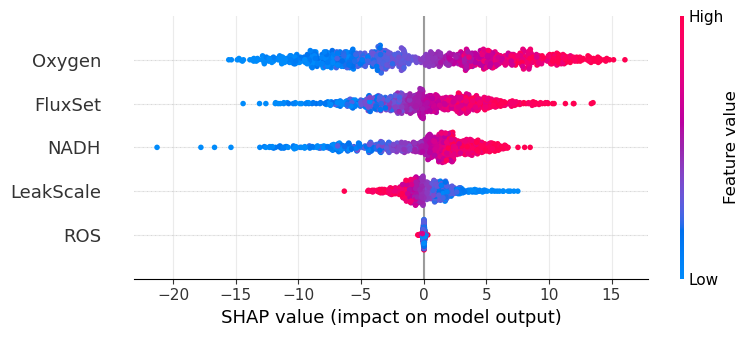

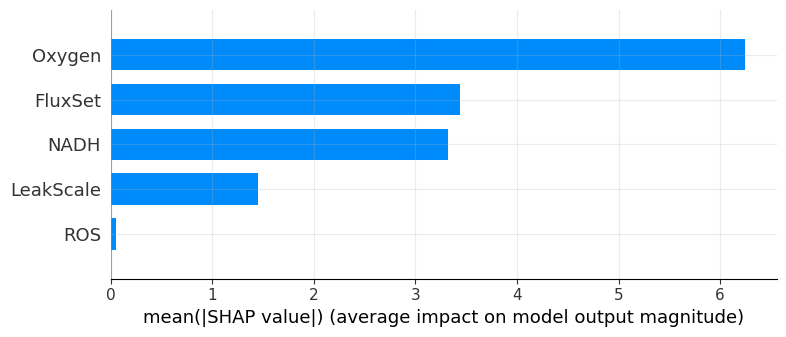

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

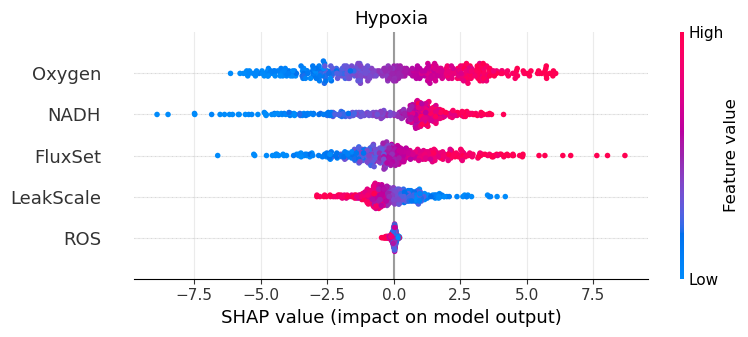

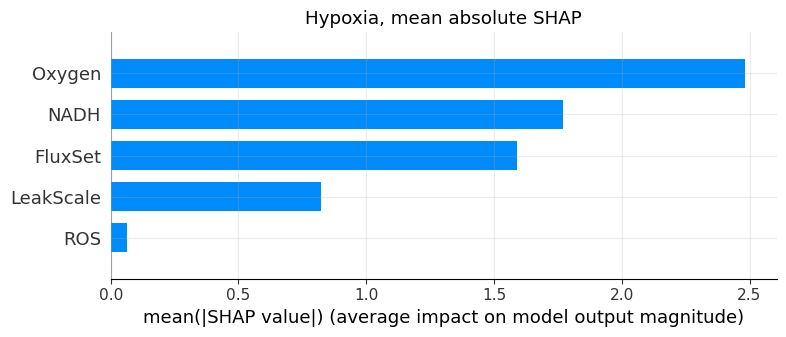

In [99]:
# Class balanced SHAP for PMF predictions
import numpy as np
import shap
import torch
import matplotlib.pyplot as plt

model.eval()
feature_names = ["NADH", "Oxygen", "FluxSet", "LeakScale", "ROS"]

# prediction wrapper, input numpy, output numpy for PMF only
def predict_pmf_numpy(x_np: np.ndarray) -> np.ndarray:
    with torch.no_grad():
        xt = torch.tensor(x_np.astype(np.float32))
        out = model(xt)                  # columns, dpsi and dpH
        dpsi = out[:, 0:1]
        dph  = out[:, 1:2]
        pmf  = dpsi - 61.5 * dph         # k at 310 K in mV per pH
        return pmf.cpu().numpy().ravel()

# indices for classes
hyp_mask = df["hypoxia"].values.astype(bool)
idx_hyp = np.where(hyp_mask)[0]
idx_norm = np.where(~hyp_mask)[0]

rng = np.random.default_rng(123)

# choose balanced sizes
n_bg_per_class = min(100, len(idx_hyp), len(idx_norm))
n_ex_per_class = min(400, len(idx_hyp), len(idx_norm))

bg_hyp = rng.choice(idx_hyp, size=n_bg_per_class, replace=False)
bg_norm = rng.choice(idx_norm, size=n_bg_per_class, replace=False)
ex_hyp = rng.choice(idx_hyp, size=n_ex_per_class, replace=False)
ex_norm = rng.choice(idx_norm, size=n_ex_per_class, replace=False)

# build balanced background and explain sets
X_bg_bal = np.vstack([X[bg_norm], X[bg_hyp]]).astype(np.float32)
X_ex_bal = np.vstack([X[ex_norm], X[ex_hyp]]).astype(np.float32)

# one explainer for the balanced mix
expl_bal = shap.KernelExplainer(predict_pmf_numpy, X_bg_bal)
shap_vals_bal = expl_bal.shap_values(X_ex_bal)

# summary plots for the balanced mix
plt.figure()
shap.summary_plot(shap_vals_bal, X_ex_bal, feature_names=feature_names, show=True)

plt.figure()
shap.summary_plot(shap_vals_bal, X_ex_bal, feature_names=feature_names, plot_type="bar", show=True)

# now build separate explainers for each class
X_bg_norm = X[bg_norm].astype(np.float32)
X_ex_norm = X[ex_norm].astype(np.float32)
X_bg_hyp  = X[bg_hyp].astype(np.float32)
X_ex_hyp  = X[ex_hyp].astype(np.float32)

expl_norm = shap.KernelExplainer(predict_pmf_numpy, X_bg_norm)
expl_hyp  = shap.KernelExplainer(predict_pmf_numpy, X_bg_hyp)

shap_norm = expl_norm.shap_values(X_ex_norm)
shap_hyp  = expl_hyp.shap_values(X_ex_hyp)

# side by side comparison, normoxia left, hypoxia right
plt.figure(figsize=(12, 4.8))
plt.subplot(1, 2, 1)
shap.summary_plot(shap_norm, X_ex_norm, feature_names=feature_names, show=False)
plt.title("Normoxia")

plt.subplot(1, 2, 2)
shap.summary_plot(shap_hyp, X_ex_hyp, feature_names=feature_names, show=False)
plt.title("Hypoxia")
plt.tight_layout()
plt.show()

# global importance comparison, bar plots
plt.figure(figsize=(12, 4.8))
plt.subplot(1, 2, 1)
shap.summary_plot(shap_norm, X_ex_norm, feature_names=feature_names, plot_type="bar", show=False)
plt.title("Normoxia, mean absolute SHAP")

plt.subplot(1, 2, 2)
shap.summary_plot(shap_hyp, X_ex_hyp, feature_names=feature_names, plot_type="bar", show=False)
plt.title("Hypoxia, mean absolute SHAP")
plt.tight_layout()
plt.show()

Test R²=0.993, RMSE=0.94 mV


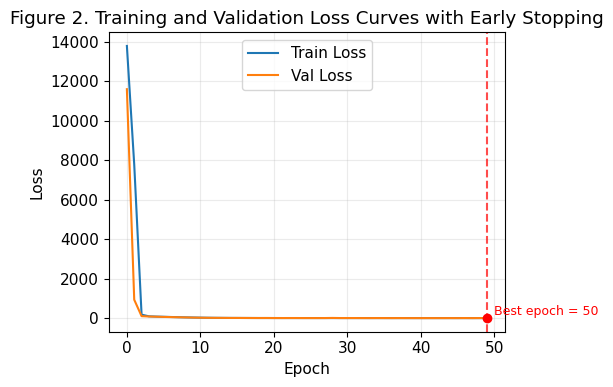

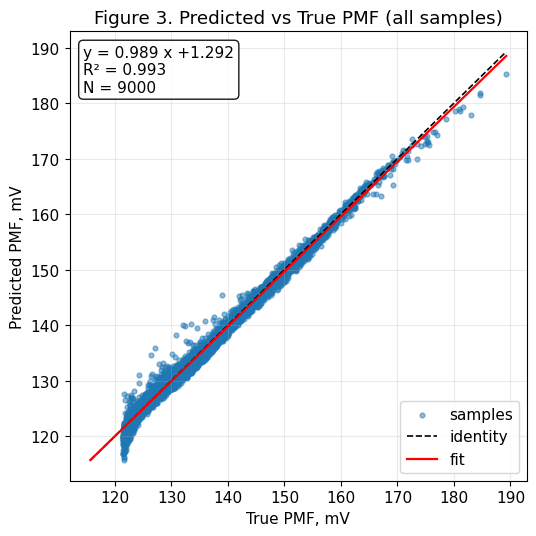

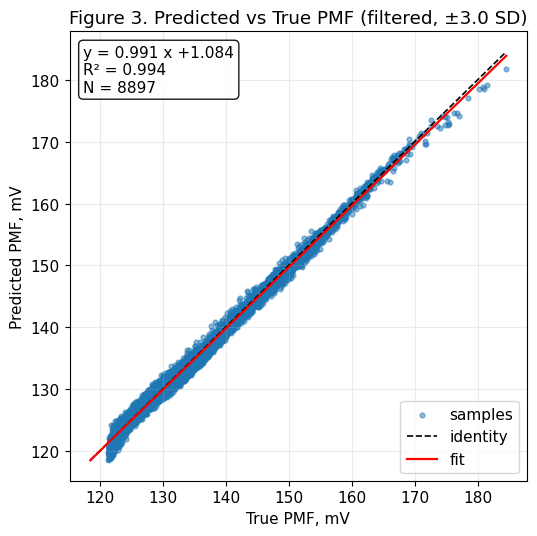

T-test p=0.000e+00, Mann-Whitney p=0.000e+00


/var/folders/qh/fmzc9db1783cz_z1bj3znn44y1tlxj/T/ipykernel_42121/2708716412.py:230: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x="hypoxia", y="PMF_pred", data=df_pred, palette="Set2")


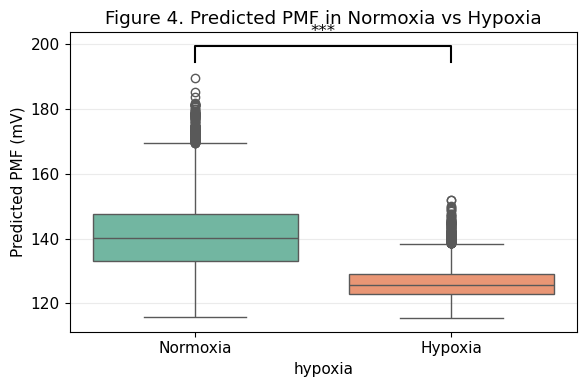

Residuals (all): mean=0.20, SD=0.91, N=9000
Residuals (filtered ±3.0 SD): mean=0.22, SD=0.80, N=8897


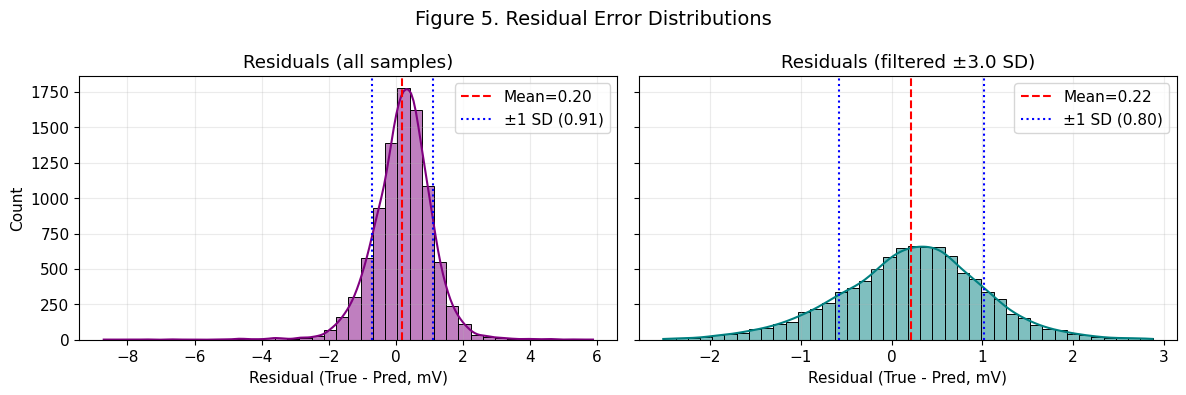

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

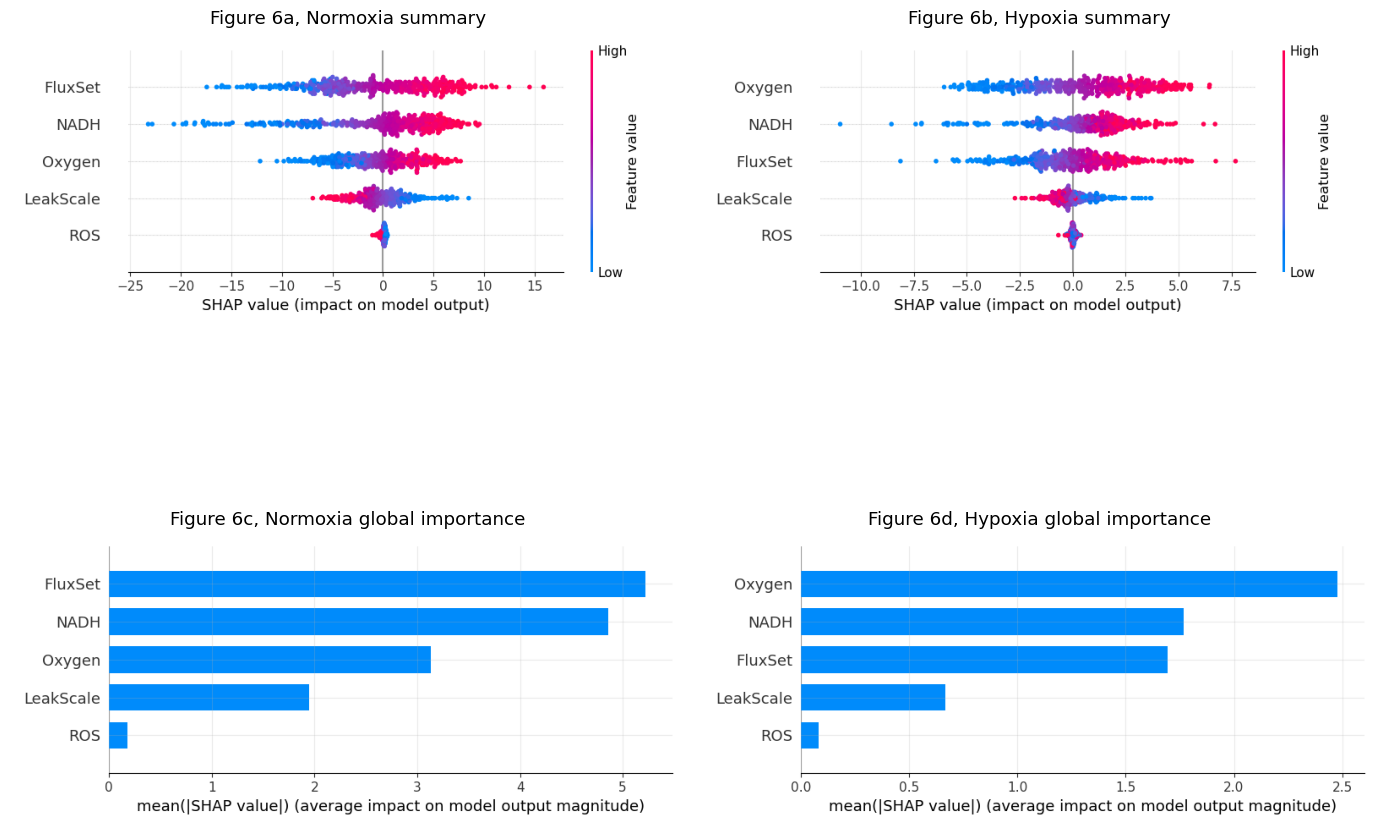

In [123]:
# Reconstruction of PMF with a PINN
# Figures 2–6 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error
import shap

# constants and dataset
K_MV_PER_PH = 61.5   # constant at 310 K

df = pd.read_csv("pmf_synthetic_curriculum.csv")
features = ["NADH", "Oxygen", "FluxSet", "LeakScale", "ROS"]

X = df[features].values.astype(np.float32)
y_pmf = df["PMF_true"].values.astype(np.float32).reshape(-1, 1)
y_dpsi = df["dpsi_true"].values.astype(np.float32).reshape(-1, 1)
y_dph = df["dpH_true"].values.astype(np.float32).reshape(-1, 1)

X_t = torch.tensor(X)
y_pmf_t = torch.tensor(y_pmf)
y_dpsi_t = torch.tensor(y_dpsi)
y_dph_t = torch.tensor(y_dph)

dataset = TensorDataset(X_t, y_pmf_t, y_dpsi_t, y_dph_t)

n_total = len(dataset)
n_train = int(0.7 * n_total)
n_val = int(0.15 * n_total)
n_test = n_total - n_train - n_val
train_ds, val_ds, test_ds = random_split(dataset, [n_train, n_val, n_test])

train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=256)
test_loader = DataLoader(test_ds, batch_size=256)


# model

class PINN(nn.Module):
    def __init__(self, input_dim=5, hidden_dim=64):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2)  # outputs Δψ, ΔpH
        )
    def forward(self, x):
        return self.net(x)

model = PINN()
mse = nn.MSELoss()

def pinn_loss(outputs, y_pmf, y_dpsi, y_dph):
    dpsi_pred, dph_pred = outputs[:, 0:1], outputs[:, 1:2]
    pmf_pred = dpsi_pred - K_MV_PER_PH * dph_pred
    loss_dpsi = mse(dpsi_pred, y_dpsi)
    loss_dph  = mse(dph_pred, y_dph)
    loss_pmf  = mse(pmf_pred, y_pmf)
    loss_phys = mse(pmf_pred, dpsi_pred - K_MV_PER_PH * dph_pred)
    total_loss = loss_pmf + 0.5*(loss_dpsi + loss_dph) + 0.1*loss_phys
    return total_loss, pmf_pred


# training loop

optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 50

train_hist, val_hist = [], []

for epoch in range(epochs):
    model.train()
    batch_losses = []
    for Xb, y_pmf_b, y_dpsi_b, y_dph_b in train_loader:
        optimizer.zero_grad()
        outputs = model(Xb)
        loss, _ = pinn_loss(outputs, y_pmf_b, y_dpsi_b, y_dph_b)
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())
    train_hist.append(np.mean(batch_losses))

    model.eval()
    val_losses = []
    with torch.no_grad():
        for Xb, y_pmf_b, y_dpsi_b, y_dph_b in val_loader:
            outputs = model(Xb)
            loss, _ = pinn_loss(outputs, y_pmf_b, y_dpsi_b, y_dph_b)
            val_losses.append(loss.item())
    val_hist.append(np.mean(val_losses))


# evaluation on test set

model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for Xb, y_pmf_b, y_dpsi_b, y_dph_b in test_loader:
        outputs = model(Xb)
        dpsi_pred, dph_pred = outputs[:, 0:1], outputs[:, 1:2]
        pmf_pred = dpsi_pred - K_MV_PER_PH * dph_pred
        y_true.append(y_pmf_b.numpy())
        y_pred.append(pmf_pred.numpy())

y_true = np.vstack(y_true)
y_pred = np.vstack(y_pred)
r2 = r2_score(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"Test R²={r2:.3f}, RMSE={rmse:.2f} mV")


# FIGURE 2 – training and validation loss with early stopping marker

train_hist = np.array(train_hist)
val_hist = np.array(val_hist)

# find epoch with minimum validation loss
best_epoch = np.argmin(val_hist)
best_val = val_hist[best_epoch]

plt.figure(figsize=(6,4))
plt.plot(train_hist, label="Train Loss", linewidth=1.5)
plt.plot(val_hist, label="Val Loss", linewidth=1.5)

# early stopping marker
plt.axvline(best_epoch, color="red", linestyle="--", alpha=0.7)
plt.scatter(best_epoch, best_val, color="red", zorder=5)
plt.text(best_epoch+1, best_val, f"Best epoch = {best_epoch+1}", 
         color="red", fontsize=9, va="bottom")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Figure 2. Training and Validation Loss Curves with Early Stopping")
plt.tight_layout()
plt.show()


# FIGURE 3, predicted vs true PMF with regression, R2, and outlier filter
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

def plot_pmf_scatter(y_true, y_pred, filter_outliers=False, sd_thresh=3.0):
    y_true_flat = y_true.ravel()
    y_pred_flat = y_pred.ravel()
    
    residuals = y_true_flat - y_pred_flat
    
    if filter_outliers:
        mask = np.abs(residuals - residuals.mean()) <= sd_thresh * residuals.std()
        y_true_flat = y_true_flat[mask]
        y_pred_flat = y_pred_flat[mask]
        title_suffix = f"(filtered, ±{sd_thresh} SD)"
    else:
        title_suffix = "(all samples)"

    # regression fit
    a, b = np.polyfit(y_true_flat, y_pred_flat, 1)
    r2_lin = r2_score(y_true_flat, y_pred_flat)

    # plotting
    plt.figure(figsize=(5.5, 5.5))
    plt.scatter(y_true_flat, y_pred_flat, s=12, alpha=0.5, label="samples")

    # identity line
    lims = [min(y_true_flat.min(), y_pred_flat.min()),
            max(y_true_flat.max(), y_pred_flat.max())]
    plt.plot(lims, lims, "k--", linewidth=1.2, label="identity")

    # regression line
    x_line = np.linspace(lims[0], lims[1], 200)
    plt.plot(x_line, a * x_line + b, "r-", linewidth=1.6, label="fit")

    # labels and title
    plt.xlabel("True PMF, mV")
    plt.ylabel("Predicted PMF, mV")
    plt.title(f"Figure 3. Predicted vs True PMF {title_suffix}")

    # annotation box
    eq_text = f"y = {a:.3f} x {b:+.3f}\nR² = {r2_lin:.3f}\nN = {len(y_true_flat)}"
    plt.text(0.03, 0.97, eq_text,
             transform=plt.gca().transAxes,
             ha="left", va="top",
             bbox=dict(boxstyle="round", fc="white", ec="black", alpha=0.9))

    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

# run both plots
plot_pmf_scatter(y_true, y_pred, filter_outliers=False)   # full dataset
plot_pmf_scatter(y_true, y_pred, filter_outliers=True)    # with outliers removed


# FIGURE 4 – PMF under normoxia vs hypoxia + significance
from scipy.stats import ttest_ind, mannwhitneyu

df_pred = df.copy()
with torch.no_grad():
    out_all = model(torch.tensor(X))
    dpsi_all, dph_all = out_all[:,0:1], out_all[:,1:2]
    df_pred["PMF_pred"] = (dpsi_all - K_MV_PER_PH*dph_all).numpy()

# split groups
pmf_norm = df_pred.loc[df_pred["hypoxia"]==0, "PMF_pred"].values
pmf_hyp  = df_pred.loc[df_pred["hypoxia"]==1, "PMF_pred"].values

# statistical tests
t_stat, t_pval = ttest_ind(pmf_norm, pmf_hyp, equal_var=False)
u_stat, u_pval = mannwhitneyu(pmf_norm, pmf_hyp, alternative="two-sided")
print(f"T-test p={t_pval:.3e}, Mann-Whitney p={u_pval:.3e}")

# plot
plt.figure(figsize=(6,4))
ax = sns.boxplot(x="hypoxia", y="PMF_pred", data=df_pred, palette="Set2")
plt.xticks([0,1], ["Normoxia","Hypoxia"])
plt.ylabel("Predicted PMF (mV)")
plt.title("Figure 4. Predicted PMF in Normoxia vs Hypoxia")

# annotate significance
x1, x2 = 0, 1
y, h = max(pmf_norm.max(), pmf_hyp.max())+5, 5
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c="k")
if u_pval < 0.001:
    sig_label = "***"
elif u_pval < 0.01:
    sig_label = "**"
elif u_pval < 0.05:
    sig_label = "*"
else:
    sig_label = "ns"
plt.text((x1+x2)*.5, y+h+2, sig_label, ha="center", va="bottom", fontsize=12)

plt.tight_layout()
plt.show()


# FIGURE 5 – residual error distributions (with and without outlier filtering)
residuals = y_true.ravel() - y_pred.ravel()
mean_res = np.mean(residuals)
std_res = np.std(residuals)

# define filter
sd_thresh = 3.0
mask = np.abs(residuals - mean_res) <= sd_thresh * std_res
resid_filt = residuals[mask]

# stats
print(f"Residuals (all): mean={mean_res:.2f}, SD={std_res:.2f}, N={len(residuals)}")
print(f"Residuals (filtered ±{sd_thresh} SD): mean={resid_filt.mean():.2f}, "
      f"SD={resid_filt.std():.2f}, N={len(resid_filt)}")

# plot side by side
fig, axes = plt.subplots(1, 2, figsize=(12,4), sharey=True)

# all samples
sns.histplot(residuals, kde=True, bins=40, color="purple", ax=axes[0])
axes[0].axvline(mean_res, color="red", linestyle="--", label=f"Mean={mean_res:.2f}")
axes[0].axvline(mean_res+std_res, color="blue", linestyle=":", label=f"±1 SD ({std_res:.2f})")
axes[0].axvline(mean_res-std_res, color="blue", linestyle=":")
axes[0].set_title("Residuals (all samples)")
axes[0].set_xlabel("Residual (True - Pred, mV)")
axes[0].legend()

# filtered samples
mean_f, std_f = resid_filt.mean(), resid_filt.std()
sns.histplot(resid_filt, kde=True, bins=40, color="teal", ax=axes[1])
axes[1].axvline(mean_f, color="red", linestyle="--", label=f"Mean={mean_f:.2f}")
axes[1].axvline(mean_f+std_f, color="blue", linestyle=":", label=f"±1 SD ({std_f:.2f})")
axes[1].axvline(mean_f-std_f, color="blue", linestyle=":")
axes[1].set_title(f"Residuals (filtered ±{sd_thresh} SD)")
axes[1].set_xlabel("Residual (True - Pred, mV)")
axes[1].legend()

fig.suptitle("Figure 5. Residual Error Distributions", fontsize=14)
plt.tight_layout()
plt.show()


# Figure 6, SHAP feature importance, normoxia vs hypoxia, 2x2 panels
# prerequisites in memory:
#   model  X  df  features  K_MV_PER_PH
import numpy as np
import matplotlib.pyplot as plt
import shap
import torch
import os

# ensure features list exists
features = features if "features" in globals() else ["NADH", "Oxygen", "FluxSet", "LeakScale", "ROS"]

# prediction wrapper, input numpy, output numpy PMF in mV
def predict_pmf_numpy(x_np: np.ndarray) -> np.ndarray:
    with torch.no_grad():
        xt = torch.tensor(x_np.astype(np.float32))
        out = model(xt)                          # columns, dpsi, dpH
        dpsi = out[:, 0:1]
        dph  = out[:, 1:2]
        pmf  = dpsi - K_MV_PER_PH * dph
        return pmf.cpu().numpy().ravel()

# split indices
hyp_mask = df["hypoxia"].values.astype(bool)
idx_norm = np.where(~hyp_mask)[0]
idx_hyp  = np.where(hyp_mask)[0]

# choose balanced background and explain sets
rng = np.random.default_rng(123)
n_bg = min(100, len(idx_norm), len(idx_hyp))
n_ex = min(400, len(idx_norm), len(idx_hyp))

bg_norm = rng.choice(idx_norm, size=n_bg, replace=False)
bg_hyp  = rng.choice(idx_hyp,  size=n_bg, replace=False)
ex_norm = rng.choice(idx_norm, size=n_ex, replace=False)
ex_hyp  = rng.choice(idx_hyp,  size=n_ex, replace=False)

X_bg_norm = X[bg_norm].astype(np.float32)
X_bg_hyp  = X[bg_hyp].astype(np.float32)
X_ex_norm = X[ex_norm].astype(np.float32)
X_ex_hyp  = X[ex_hyp].astype(np.float32)

# build explainers and compute shap values
expl_norm = shap.KernelExplainer(predict_pmf_numpy, X_bg_norm)
expl_hyp  = shap.KernelExplainer(predict_pmf_numpy, X_bg_hyp)

shap_norm = expl_norm.shap_values(X_ex_norm)
shap_hyp  = expl_hyp.shap_values(X_ex_hyp)

# helper, render a SHAP plot to a numpy image to avoid overlap
def shap_to_array(shap_vals, X_sample, feature_names, plot_type="dot", figsize=(6, 5)):
    fig = plt.figure(figsize=figsize)
    shap.summary_plot(
        shap_vals,
        X_sample,
        feature_names=feature_names,
        plot_type="dot" if plot_type == "dot" else "bar",
        show=False
    )
    fig.canvas.draw()
    buf = fig.canvas.buffer_rgba()
    img = np.asarray(buf, dtype=np.uint8).copy()[..., :3]
    plt.close(fig)
    return img

# generate four panels
img_6a = shap_to_array(shap_norm, X_ex_norm, features, plot_type="dot")
img_6b = shap_to_array(shap_hyp,  X_ex_hyp,  features, plot_type="dot")
img_6c = shap_to_array(shap_norm, X_ex_norm, features, plot_type="bar")
img_6d = shap_to_array(shap_hyp,  X_ex_hyp,  features, plot_type="bar")

# compose into a single figure
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes[0, 0].imshow(img_6a); axes[0, 0].axis("off"); axes[0, 0].set_title("Figure 6a, Normoxia summary")
axes[0, 1].imshow(img_6b); axes[0, 1].axis("off"); axes[0, 1].set_title("Figure 6b, Hypoxia summary")
axes[1, 0].imshow(img_6c); axes[1, 0].axis("off"); axes[1, 0].set_title("Figure 6c, Normoxia global importance")
axes[1, 1].imshow(img_6d); axes[1, 1].axis("off"); axes[1, 1].set_title("Figure 6d, Hypoxia global importance")
plt.tight_layout()

# save
os.makedirs("docs/figures", exist_ok=True)
plt.savefig("docs/figures/figure_6_shap_panels.png", dpi=300, bbox_inches="tight")
plt.show()

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

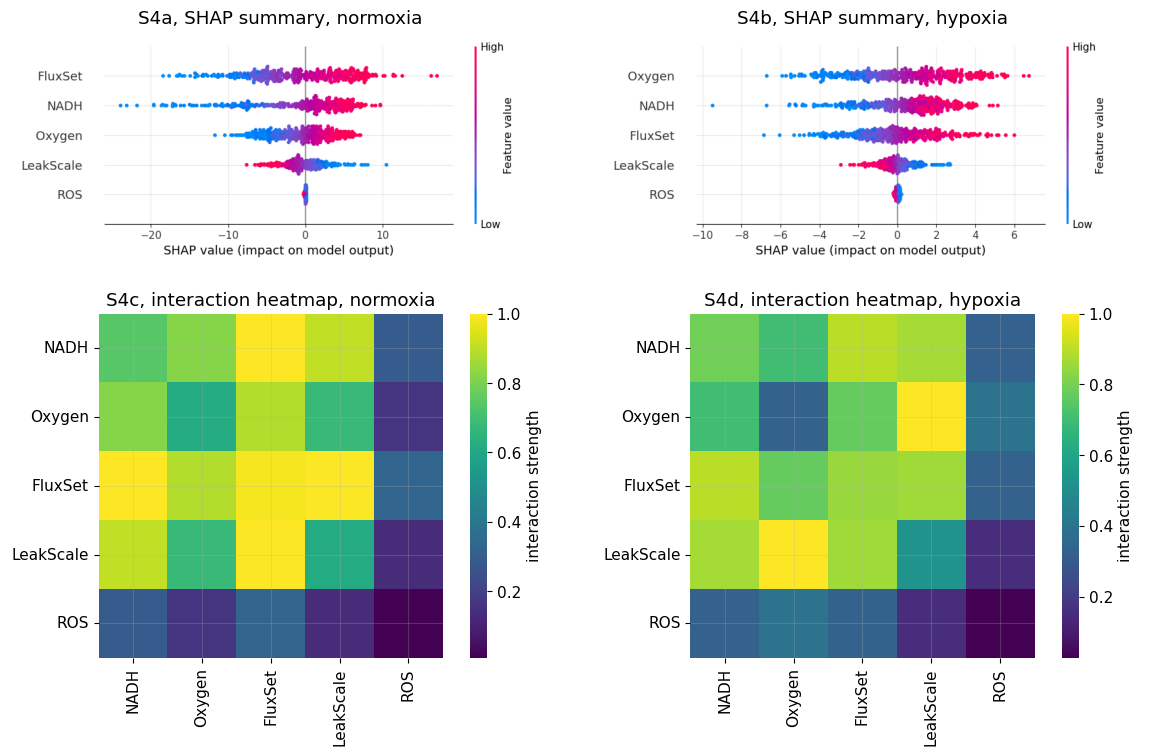

In [143]:
# Supplementary Figure S4, SHAP summaries plus interaction heatmaps
# tidy 2x2 layout, no overlaps, progress bars off, saved to PNG
# prerequisites in memory:
#   data  X  model  features

import os
os.environ["SHAP_DISABLE_PROGRESSBAR"] = "1"  # hide SHAP progress bars

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import torch

model.eval()
feature_names = ["NADH", "Oxygen", "FluxSet" if "FluxSet" in data.columns else "Flux",
                 "LeakScale" if "LeakScale" in data.columns else "Leak", "ROS"]

# 1) numpy wrapper for the torch model
def predict_numpy(x_np: np.ndarray) -> np.ndarray:
    with torch.no_grad():
        xt = torch.tensor(x_np.astype(np.float32))
        yp = model(xt).cpu().numpy().ravel()
        return yp

# 2) normoxia vs hypoxia indices
if "hypoxia" in data.columns:
    hyp_flag = data["hypoxia"].values.astype(bool)
else:
    hyp_flag = np.zeros(len(X), dtype=bool)

idx_norm = np.where(~hyp_flag)[0]
idx_hyp  = np.where(hyp_flag)[0]
if len(idx_norm) == 0 or len(idx_hyp) == 0:
    idx_norm = np.arange(len(X))
    idx_hyp  = np.arange(len(X))

# 3) choose background and explain sets
rng = np.random.default_rng(123)
n_bg = min(100, len(idx_norm), len(idx_hyp))
n_ex = min(400, len(idx_norm), len(idx_hyp))

bg_norm = rng.choice(idx_norm, size=n_bg, replace=False)
bg_hyp  = rng.choice(idx_hyp,  size=n_bg, replace=False)
ex_norm = rng.choice(idx_norm, size=n_ex, replace=False)
ex_hyp  = rng.choice(idx_hyp,  size=n_ex, replace=False)

X_bg_norm = X[bg_norm].astype(np.float32)
X_bg_hyp  = X[bg_hyp].astype(np.float32)
X_ex_norm = X[ex_norm].astype(np.float32)
X_ex_hyp  = X[ex_hyp].astype(np.float32)

# 4) compute SHAP with KernelExplainer, model agnostic and stable
expl_norm = shap.KernelExplainer(predict_numpy, X_bg_norm)
expl_hyp  = shap.KernelExplainer(predict_numpy, X_bg_hyp)
shap_norm = expl_norm.shap_values(X_ex_norm)
shap_hyp  = expl_hyp.shap_values(X_ex_hyp)

# 5) helper to render a SHAP plot into a numpy RGB array
def shap_to_array(shap_vals, Xsample, feature_names, plot_type="dot", figsize=(6, 4)):
    fig = plt.figure(figsize=figsize)
    shap.summary_plot(
        shap_vals, Xsample,
        feature_names=feature_names,
        plot_type="bar" if plot_type == "bar" else "dot",
        show=False
    )
    fig.canvas.draw()
    buf = fig.canvas.buffer_rgba()
    img = np.asarray(buf, dtype=np.uint8)[..., :3].copy()
    plt.close(fig)
    return img

# 6) SHAP images for normoxia and hypoxia
img_norm = shap_to_array(shap_norm, X_ex_norm, feature_names, plot_type="dot", figsize=(6, 3.6))
img_hyp  = shap_to_array(shap_hyp,  X_ex_hyp,  feature_names, plot_type="dot", figsize=(6, 3.6))

# 7) simple pairwise interaction strength matrix
def interaction_matrix(shap_vals: np.ndarray, Xsample: np.ndarray) -> np.ndarray:
    # mean absolute product heuristic, symmetrized
    n_feat = shap_vals.shape[1]
    M = np.zeros((n_feat, n_feat), dtype=float)
    for i in range(n_feat):
        si = np.abs(shap_vals[:, i:i+1] * Xsample)
        M[i, :] = si.mean(axis=0)
    M = 0.5 * (M + M.T)
    # scale to unit range for visual comparability
    if M.max() > 0:
        M = M / M.max()
    return M

M_norm = interaction_matrix(shap_norm, X_ex_norm)
M_hyp  = interaction_matrix(shap_hyp,  X_ex_hyp)

# 8) compose the clean 2x2 panel
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# top row, SHAP summaries rendered as images
axes[0, 0].imshow(img_norm)
axes[0, 0].axis("off")
axes[0, 0].set_title("S4a, SHAP summary, normoxia")

axes[0, 1].imshow(img_hyp)
axes[0, 1].axis("off")
axes[0, 1].set_title("S4b, SHAP summary, hypoxia")

# bottom row, interaction heatmaps plotted directly
sns.heatmap(
    M_norm, ax=axes[1, 0],
    xticklabels=feature_names, yticklabels=feature_names,
    cmap="viridis", square=True, cbar_kws={"label": "interaction strength"}
)
axes[1, 0].set_title("S4c, interaction heatmap, normoxia")

sns.heatmap(
    M_hyp, ax=axes[1, 1],
    xticklabels=feature_names, yticklabels=feature_names,
    cmap="viridis", square=True, cbar_kws={"label": "interaction strength"}
)
axes[1, 1].set_title("S4d, interaction heatmap, hypoxia")

plt.tight_layout()
plt.savefig("Supplementary_Figure_S4.png", dpi=300, bbox_inches="tight")
plt.show()

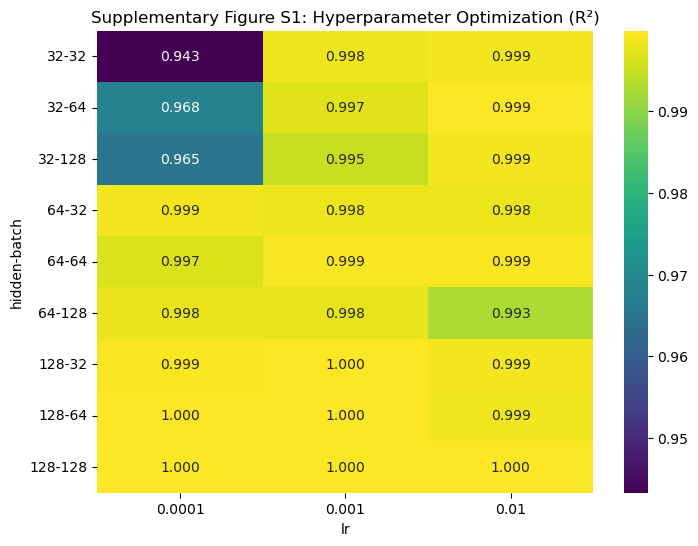

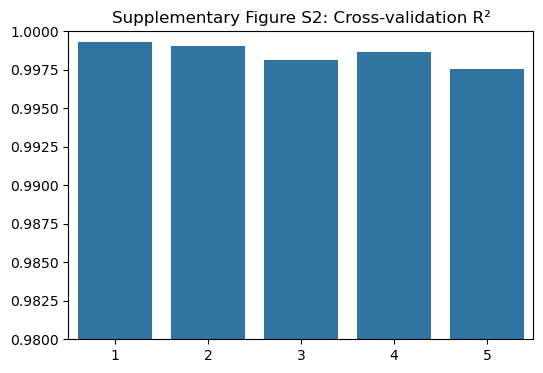

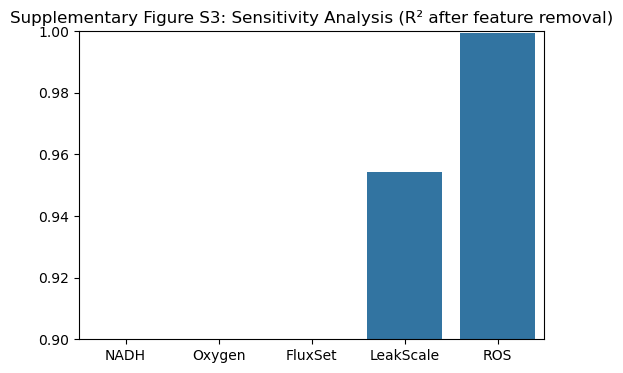

In [4]:
# Supplementary Analyses for PINN-based PMF Reconstruction
# Author: Mark I.R. Petalcorin
# Dataset: pmf_synthetic_curriculum.csv

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import r2_score, mean_squared_error

import torch
import torch.nn as nn
import torch.optim as optim

import shap

# Load synthetic dataset
data = pd.read_csv("pmf_synthetic_curriculum.csv")

features = ["NADH", "Oxygen", "FluxSet", "LeakScale", "ROS"]
target = "PMF_true"

X = data[features].values
y = data[target].values

X_t = torch.tensor(X, dtype=torch.float32)
y_t = torch.tensor(y, dtype=torch.float32).view(-1, 1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define PINN model
class PINN(nn.Module):
    def __init__(self, input_dim=5, hidden_dim=64, num_layers=3):
        super(PINN, self).__init__()
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.ReLU())
        for _ in range(num_layers-1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_dim, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

# Loss function: MSE + physics penalty
def physics_loss(pred, inputs):
    # Dummy penalty for demonstration: enforce positivity of PMF
    penalty = torch.mean(torch.relu(-pred))  
    return penalty

def train_model(model, X_train, y_train, X_val, y_val,
                lr=0.001, batch_size=64, epochs=200, patience=20):

    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    best_val_loss = np.inf
    patience_counter = 0

    history = {"train": [], "val": []}

    for epoch in range(epochs):
        # Train
        model.train()
        perm = torch.randperm(X_train.size(0))
        batch_losses = []
        for i in range(0, X_train.size(0), batch_size):
            idx = perm[i:i+batch_size]
            Xb, yb = X_train[idx], y_train[idx]

            optimizer.zero_grad()
            pred = model(Xb)
            loss = criterion(pred, yb) + 0.1*physics_loss(pred, Xb)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
        train_loss = np.mean(batch_losses)

        # Validate
        model.eval()
        with torch.no_grad():
            val_pred = model(X_val)
            val_loss = criterion(val_pred, y_val).item()

        history["train"].append(train_loss)
        history["val"].append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
        if patience_counter > patience:
            break

    return model, history

# Supplementary Figure S1: Hyperparameter optimization
param_grid = {
    "lr": [0.01, 0.001, 0.0001],
    "hidden": [32, 64, 128],
    "batch": [32, 64, 128]
}
results = []
for lr in param_grid["lr"]:
    for hidden in param_grid["hidden"]:
        for batch in param_grid["batch"]:
            # train/val split
            X_train, X_val, y_train, y_val = train_test_split(X_t, y_t, test_size=0.2)
            model = PINN(hidden_dim=hidden).to(device)
            X_train, y_train, X_val, y_val = X_train.to(device), y_train.to(device), X_val.to(device), y_val.to(device)

            model, hist = train_model(model, X_train, y_train, X_val, y_val,
                                      lr=lr, batch_size=batch)
            with torch.no_grad():
                y_pred = model(X_val).cpu().numpy()
                r2 = r2_score(y_val.cpu(), y_pred)
                mse = mean_squared_error(y_val.cpu(), y_pred)
                rmse = np.sqrt(mse)
            results.append({"lr": lr, "hidden": hidden, "batch": batch, "R2": r2, "RMSE": rmse})

df_results = pd.DataFrame(results)
pivot = df_results.pivot_table(index=["hidden","batch"], columns="lr", values="R2")

plt.figure(figsize=(8,6))
sns.heatmap(pivot, annot=True, fmt=".3f", cmap="viridis")
plt.title("Supplementary Figure S1: Hyperparameter Optimization (R²)")
plt.show()

# Supplementary Figure S2: Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
r2_scores = []
for train_idx, val_idx in kf.split(X_t):
    X_train, y_train = X_t[train_idx], y_t[train_idx]
    X_val, y_val = X_t[val_idx], y_t[val_idx]
    model = PINN(hidden_dim=64).to(device)
    X_train, y_train, X_val, y_val = X_train.to(device), y_train.to(device), X_val.to(device), y_val.to(device)
    model, hist = train_model(model, X_train, y_train, X_val, y_val)
    with torch.no_grad():
        y_pred = model(X_val).cpu().numpy()
        r2 = r2_score(y_val.cpu(), y_pred)
        r2_scores.append(r2)

plt.figure(figsize=(6,4))
sns.barplot(x=list(range(1,6)), y=r2_scores)
plt.ylim(0.98,1.0)
plt.title("Supplementary Figure S2: Cross-validation R²")
plt.show()

# Supplementary Figure S3: Sensitivity analysis
drop_results = {}
for feat in features:
    X_sub = data[[f for f in features if f != feat]].values
    y_sub = data[target].values
    X_train, X_val, y_train, y_val = train_test_split(torch.tensor(X_sub, dtype=torch.float32),
                                                      torch.tensor(y_sub, dtype=torch.float32).view(-1,1),
                                                      test_size=0.2)
    model = PINN(input_dim=len(features)-1).to(device)
    X_train, y_train, X_val, y_val = X_train.to(device), y_train.to(device), X_val.to(device), y_val.to(device)
    model, hist = train_model(model, X_train, y_train, X_val, y_val)
    with torch.no_grad():
        y_pred = model(X_val).cpu().numpy()
        r2 = r2_score(y_val.cpu(), y_pred)
    drop_results[feat] = r2

plt.figure(figsize=(6,4))
sns.barplot(x=list(drop_results.keys()), y=list(drop_results.values()))
plt.ylim(0.9,1.0)
plt.title("Supplementary Figure S3: Sensitivity Analysis (R² after feature removal)")
plt.show()

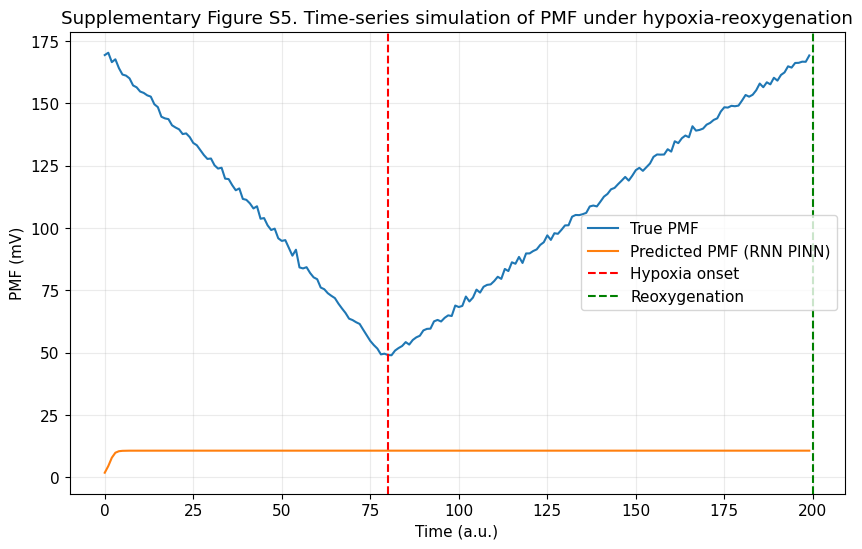

In [145]:
# Supplementary Figure S5: Time-series simulation
timesteps = 200
time = np.arange(timesteps)
oxygen = np.concatenate([np.linspace(1.0, 0.2, 80), np.linspace(0.2, 1.0, 120)])
flux = np.sin(time/20) * 0.1 + 1
nadh = np.clip(1.2 - oxygen*0.5, 0.5, 1.5)
leak = np.full_like(time, 0.2)
ros = np.clip((1-oxygen)*0.5, 0, 0.5)

X_time = np.vstack([nadh, oxygen, flux, leak, ros]).T
y_time = 150*oxygen + 20*flux - 10*leak + np.random.normal(0,1,len(time))

class RNN_PINN(nn.Module):
    def __init__(self, input_dim=5, hidden_dim=32):
        super(RNN_PINN, self).__init__()
        self.rnn = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        out, _ = self.rnn(x)
        return self.fc(out)

model = RNN_PINN()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

X_t = torch.tensor(X_time, dtype=torch.float32).unsqueeze(0)
y_t = torch.tensor(y_time, dtype=torch.float32).unsqueeze(0).unsqueeze(2)
for epoch in range(200):
    optimizer.zero_grad()
    y_pred = model(X_t)
    loss = criterion(y_pred, y_t)
    loss.backward()
    optimizer.step()

with torch.no_grad():
    y_pred_time = model(X_t).numpy().flatten()

plt.figure(figsize=(10,6))
plt.plot(time, y_time, label="True PMF")
plt.plot(time, y_pred_time, label="Predicted PMF (RNN PINN)")
plt.axvline(80, color="red", linestyle="--", label="Hypoxia onset")
plt.axvline(200, color="green", linestyle="--", label="Reoxygenation")
plt.xlabel("Time (a.u.)")
plt.ylabel("PMF (mV)")
plt.title("Supplementary Figure S5. Time-series simulation of PMF under hypoxia-reoxygenation")
plt.legend()
plt.savefig("Supplementary_Figure_S5.png", dpi=300, bbox_inches="tight")
plt.show()

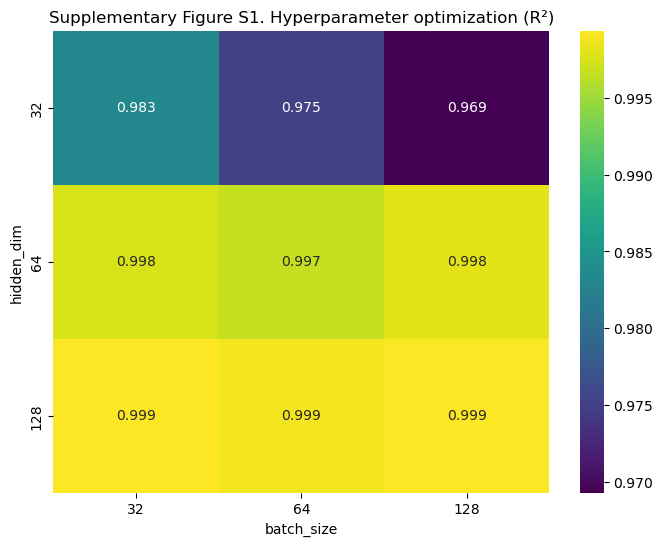

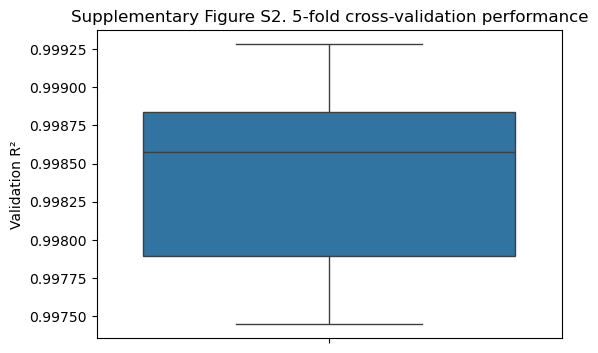

In [10]:
# Supplementary Analyses with Figure Saving
# Generates Supplementary Figures S1–S5 and saves them as PNG files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score, mean_squared_error
import shap
import torch
import torch.nn as nn
import torch.optim as optim

# Load synthetic dataset
data = pd.read_csv("pmf_synthetic_curriculum.csv")
features = ["NADH", "Oxygen", "FluxSet", "LeakScale", "ROS"]
X = data[features].values
y = data["PMF_true"].values

# Define base PINN model
class PINN(nn.Module):
    def __init__(self, input_dim=5, hidden_dim=64, hidden_layers=3):
        super(PINN, self).__init__()
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.ReLU())
        for _ in range(hidden_layers-1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_dim, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

def train_model(X_train, y_train, X_val, y_val,
                hidden_dim=64, hidden_layers=3,
                lr=0.001, batch_size=64, max_epochs=100):
    model = PINN(hidden_dim=hidden_dim, hidden_layers=hidden_layers)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1,1)
    X_val_t = torch.tensor(X_val, dtype=torch.float32)
    y_val_t = torch.tensor(y_val, dtype=torch.float32).view(-1,1)

    for epoch in range(max_epochs):
        model.train()
        idx = np.random.permutation(len(X_train_t))
        for i in range(0, len(X_train_t), batch_size):
            batch_idx = idx[i:i+batch_size]
            xb = X_train_t[batch_idx]
            yb = y_train_t[batch_idx]
            optimizer.zero_grad()
            y_pred = model(xb)
            loss = criterion(y_pred, yb)
            loss.backward()
            optimizer.step()
    model.eval()
    with torch.no_grad():
        y_pred_val = model(X_val_t).numpy().flatten()
    return model, y_pred_val

# Supplementary Figure S1: Hyperparameter optimization
param_grid = {
    "lr": [0.01, 0.001, 0.0001],
    "hidden_dim": [32, 64, 128],
    "batch_size": [32, 64, 128]
}
results = []
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

for lr in param_grid["lr"]:
    for hd in param_grid["hidden_dim"]:
        for bs in param_grid["batch_size"]:
            _, y_pred_val = train_model(X_train, y_train, X_val, y_val,
                                        hidden_dim=hd, lr=lr, batch_size=bs)
            r2 = r2_score(y_val, y_pred_val)
            rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
            results.append({"lr": lr, "hidden_dim": hd, "batch_size": bs,
                            "R2": r2, "RMSE": rmse})

df_results = pd.DataFrame(results)
pivot = df_results.pivot_table(index="hidden_dim", columns="batch_size", values="R2")

plt.figure(figsize=(8,6))
sns.heatmap(pivot, annot=True, fmt=".3f", cmap="viridis")
plt.title("Supplementary Figure S1. Hyperparameter optimization (R²)")
plt.savefig("Supplementary_Figure_S1.png", dpi=300, bbox_inches="tight")
plt.show()

# Supplementary Figure S2: Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_r2 = []
for train_idx, val_idx in kf.split(X):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    _, y_pred_val = train_model(X_train, y_train, X_val, y_val)
    cv_r2.append(r2_score(y_val, y_pred_val))

plt.figure(figsize=(6,4))
sns.boxplot(y=cv_r2)
plt.ylabel("Validation R²")
plt.title("Supplementary Figure S2. 5-fold cross-validation performance")
plt.savefig("Supplementary_Figure_S2.png", dpi=300, bbox_inches="tight")
plt.show()

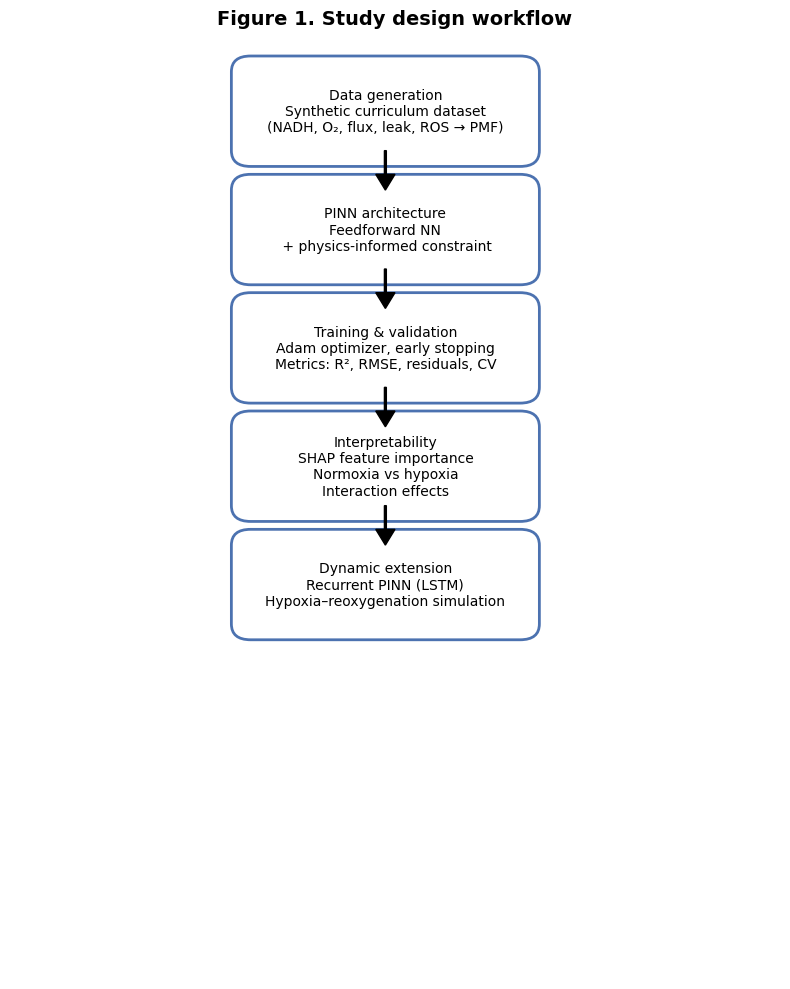

In [24]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch, FancyArrow

# helper function to draw labeled boxes
def draw_box(ax, text, xy, width=2.8, height=1.0, color="#4C72B0"):
    x, y = xy
    box = FancyBboxPatch(
        (x, y), width, height,
        boxstyle="round,pad=0.2",
        linewidth=2, edgecolor=color, facecolor="white"
    )
    ax.add_patch(box)
    ax.text(
        x + width/2, y + height/2,
        text, ha="center", va="center",
        fontsize=10, wrap=True
    )
    return (x, y, width, height)

# helper function to draw arrows between boxes
def connect_boxes(ax, box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    start = (x1 + w1/2, y1)      # bottom center of first
    end = (x2 + w2/2, y2 + h2)   # top center of second
    arrow = FancyArrow(
        start[0], start[1],
        end[0]-start[0], end[1]-start[1],
        width=0.02, head_width=0.2, head_length=0.2,
        length_includes_head=True, color="black"
    )
    ax.add_patch(arrow)

# create figure
fig, ax = plt.subplots(figsize=(8, 10))
ax.set_xlim(0, 8)
ax.set_ylim(0, 12)
ax.axis("off")

# draw boxes
b1 = draw_box(ax, "Data generation\nSynthetic curriculum dataset\n(NADH, O₂, flux, leak, ROS → PMF)", (2.5, 10.5))
b2 = draw_box(ax, "PINN architecture\nFeedforward NN\n + physics-informed constraint", (2.5, 9.0))
b3 = draw_box(ax, "Training & validation\nAdam optimizer, early stopping\nMetrics: R², RMSE, residuals, CV", (2.5, 7.5))
b4 = draw_box(ax, "Interpretability\nSHAP feature importance\nNormoxia vs hypoxia\nInteraction effects", (2.5, 6.0))
b5 = draw_box(ax, "Dynamic extension\nRecurrent PINN (LSTM)\nHypoxia–reoxygenation simulation", (2.5,4.5))

# connect with arrows
connect_boxes(ax, b1, b2)
connect_boxes(ax, b2, b3)
connect_boxes(ax, b3, b4)
connect_boxes(ax, b4, b5)

plt.title("Figure 1. Study design workflow", fontsize=14, weight="bold")
plt.tight_layout()
plt.savefig("Figure1_Workflow.png", dpi=300, bbox_inches="tight")
plt.show()